In [16]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import os 

# 1. opening the data
file = os.path.normpath(r'T:\\freely_moving_ephys\ephys_recordings\031021\EE11P13LTRN\fm1\031021_EE11P13LTRN_control_Rig2_fm1_imu.nc')
with xr.open_dataset(file) as ds: 
    print(ds.keys())

data = ds.IMU_data ### saves the Datasets DataArray

# 2. Time

timestamps = data.coords['timestamps'] ### seconds past midnight

diff = np.diff(timestamps) ### gives the difference between timestamps (in seconds)

t = np.zeros([len(timestamps),1]) ### gives a list of seconds over trial period
for i in range(len(diff)):
    t[1+i] = t[i] + diff[i]

# 3. Isolating acceleration and gyro measurments (volts)
acc = data[:,0:3]
gyro = data[:,3:6]

# 4. Converting acceleration and gyro units
gyro = (gyro-np.mean(gyro))*(400) ### 1V = 400deg/sec ... mean(gyro) centers data around 0

acc = (acc-2.5)*1.6 # convert to: g = m/s^2

# 5. Saving Acc and Gyro as ndarrays
acc = acc.data
gyro = gyro.data

KeysView(<xarray.Dataset>
Dimensions:     (channel: 544318, sample: 6)
Coordinates:
  * channel     (channel) int64 0 100 200 300 ... 54431500 54431600 54431700
  * sample      (sample) object 'acc_x' 'acc_y' 'acc_z' ... 'gyro_y' 'gyro_z'
    timestamps  (channel) float64 ...
Data variables:
    IMU_data    (channel, sample) float64 ...)


In [10]:
import typing
from time import time

from scipy.spatial import distance
from scipy.spatial.transform import Rotation as R
from scipy.optimize import curve_fit

from autopilot.transform.geometry import IMU_Orientation

In [11]:
IMU = IMU_Orientation()

c:\users\niell lab\documents\github\autopilot\autopilot\prefs.py:399: UserWarning: Returning default prefs value LOGLEVEL : WARNING (ideally this shouldnt happen and everything should be specified in prefs
  warnings.warn(f'Returning default prefs value {key} : {default_val} (ideally this shouldnt happen and everything should be specified in prefs', UserWarning)
c:\users\niell lab\documents\github\autopilot\autopilot\prefs.py:399: UserWarning: Returning default prefs value LOGDIR : C:\Users\Niell Lab\autopilot\logs (ideally this shouldnt happen and everything should be specified in prefs
  warnings.warn(f'Returning default prefs value {key} : {default_val} (ideally this shouldnt happen and everything should be specified in prefs', UserWarning)
c:\users\niell lab\documents\github\autopilot\autopilot\prefs.py:399: UserWarning: Returning default prefs value LOGSIZE : 5242880 (ideally this shouldnt happen and everything should be specified in prefs
  warnings.warn(f'Returning default prefs

In [12]:
def IMU_roll_pitch(acceleration, gyroscope): ### input two ndarrays for acc and gyro data
    if len(acceleration) == len(gyroscope):
        roll_pitch = np.zeros([len(acc),2])
        for x in range(len(acceleration)):
            roll_pitch[x,:] = IMU.process((acceleration[x,:],gyroscope[x,:]))### update by row
        return(roll_pitch)
    else:
        print('acc or gyro error: input arguments must be of equal size')

In [13]:
RPT = np.append(IMU_roll_pitch(acc,gyro), t , axis=1) ### columns = Roll/Pitch/Time

In [101]:
ori = IMU_roll_pitch(acc,gyro)

In [102]:
ori.shape

(544318, 2)

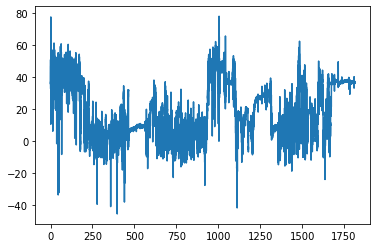

In [104]:
plt.plot(t,ori[:,0])

In [19]:
file2 = os.path.normpath(r'T:\\freely_moving_ephys\ephys_recordings\031021\EE11P13LTRN\fm1\031021_EE11P13LTRN_control_Rig2_fm1_TOP1.nc')
top = xr.open_dataset(file2) 

In [41]:
top['TOP1_pts']

<xarray.DataArray 'TOP1_pts' (point_loc: 48, frame: 108873)>
[5225904 values with dtype=float64]
Coordinates:
  * frame       (frame) int64 0 1 2 3 4 5 ... 108868 108869 108870 108871 108872
  * point_loc   (point_loc) object 'nose_x' 'nose_y' ... 'BRcorner_likelihood'
    timestamps  (frame) float64 ...
    trial       <U40 '031021_EE11P13LTRN_control_Rig2_fm1_TOP1'

In [44]:
learx = top['TOP1_pts'].sel(point_loc='leftear_x').data
leary = top['TOP1_pts'].sel(point_loc='leftear_y').data
rearx = top['TOP1_pts'].sel(point_loc='rightear_x').data
reary = top['TOP1_pts'].sel(point_loc='rightear_y').data

In [68]:
eliney = np.array([leary,reary])
elinex = np.array([learx,rearx])
print(eliney[:,dt],elinex[:,dt])

[260.92788696 266.39358521] [203.07647705 183.68247986]


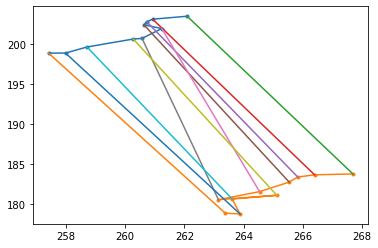

In [71]:
dt = 10
plt.plot(leary[:dt],learx[:dt], '.-')
plt.plot(reary[:dt],rearx[:dt], '.-')
plt.plot(eliney[:,:dt],elinex[:,:dt])

# plt.plot([leary[:dt],reary[:dt]],[learx[:dt],rearx[:dt]])

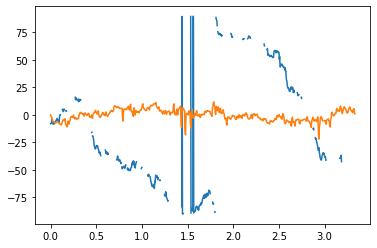

In [100]:
headang = np.arctan2(eliney[0]-eliney[1],elinex[0]-elinex[1])*180/(2*np.pi)
plt.plot(RPT[:1000,-1],headang[:1000])
plt.plot(RPT[:1000,-1],RPT[:1000,1])
# plt.show()

In [86]:
headang.shape

(108873,)

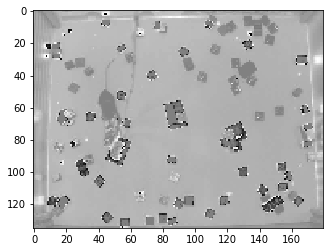

In [81]:
plt.imshow(top['TOP1_video'].sel(frame=0),cmap='gray')
# plt.plot(eliney[:,:dt],elinex[:,:dt],'.-')

In [109]:
%pwd

'C:\\Users\\Niell Lab\\Documents\\GitHub\\FreelyMovingEphys\\project_analysis\\misc'

In [110]:
os.path.join('C:\\Users\\Niell Lab\\Documents\\GitHub\\FreelyMovingEphys\\')

'C:\\Users\\Niell Lab\\Documents\\GitHub\\FreelyMovingEphys\\'

In [115]:
import sys
import pandas as pd
import xarray as xr
import pandas as pd
import numpy as np
from scipy.signal import medfilt

from util.time import open_time1
sys.path.insert(0, os.path.join('C:\\Users\\Niell Lab\\Documents\\GitHub\\FreelyMovingEphys\\'))

from util.config import set_preprocessing_config_defaults, str_to_bool, open_config
config_path = os.path.normpath(r'T:\\freely_moving_ephys\ephys_recordings\031021\EE11P13LTRN\config.yaml')
config = open_config(config_path)

In [116]:
# def read_8ch_imu(imupath, timepath, config):
imupath = os.path.normpath(r'T:\\freely_moving_ephys\ephys_recordings\031021\EE11P13LTRN\fm1\031021_EE11P13LTRN_control_Rig2_fm1_IMU.bin')
timepath =  os.path.normpath(r'T:\\freely_moving_ephys\ephys_recordings\031021\EE11P13LTRN\fm1\031021_EE11P13LTRN_control_Rig2_fm1_Ephys_BonsaiBoardTS.csv')
"""
read an 8-channel binary file of variable length
INPUTS:
    imupath -- imu binary file
    timepath -- timestamp csv file to imu data
    config -- options dict
OUTPUTS:
    imu_out -- xarray of IMU data
only channels 0-3, 4-7 will be saved out, channels, 3 and 7 are thrown out
expected binary channel order: acc first, empty channel, then gyro, then empty channel
returns a dataarray of constructed timestamps and imu readings from -5V to 5V
dataarray values are downsampled by value in input dictionary config
"""
# set up datatypes and names for each channel
dtypes = np.dtype([
    ("acc_x",np.uint16),
    ("acc_y",np.uint16),
    ("acc_z",np.uint16),
    ("none1",np.uint16),
    ("gyro_x",np.uint16),
    ("gyro_y",np.uint16),
    ("gyro_z",np.uint16),
    ("none2",np.uint16)
])
# read in binary file
binary_in = pd.DataFrame(np.fromfile(imupath, dtypes, -1, ''))
binary_in = binary_in.drop(columns=['none1','none2'])
# convert to -5V to 5V
data = 10 * (binary_in.astype(float)/(2**16) - 0.5)
# downsample
data = data.iloc[0:-1:config['imu_downsample'],:]
samp_freq = config['imu_sample_rate'] / config['imu_downsample']
# read in timestamps
time = pd.DataFrame(open_time1(pd.read_csv(timepath).iloc[:,0]))
# get first/last timepoint, num_samples
t0 = time.iloc[0,0]; num_samp = np.size(data,0)
# samples start at t0, and are acquired at rate of 'ephys_sample_rate'/ 'imu_downsample'
newtime = pd.DataFrame(np.array(t0 + np.linspace(0, num_samp-1, num_samp) / samp_freq))
# collect the data together to return

In [130]:
# all_data = data.copy()
# all_data.columns = ['acc_x', 'acc_y', 'acc_z', 'gyro_x', 'gyro_y', 'gyro_z']
# acc = all_data[['acc_x', 'acc_y', 'acc_z']].to_numpy()
# gyro = all_data[['gyro_x', 'gyro_y', 'gyro_z']].to_numpy()
# orientation = IMU_roll_pitch(acc,gyro)
all_data['roll'] = orientation[:,0].astype(np.float16) # Roll
all_data['pitch'] = orientation[:,1].astype(np.float16) # Pitch
imu_out = xr.DataArray(all_data, dims={'channel','sample'})
try:
    imu_out = imu_out.assign_coords(timestamps=('sample',list(newtime.iloc[:,0])))
except ValueError:
    imu_out = imu_out.assign_coords(timestamps=('channel',list(newtime.iloc[:,0])))       

#     return imu_out

In [122]:
imu_out = xr.DataArray(all_data, dims={'channel','sample'})


In [131]:
all_data['roll']

0           36.34375
100         36.62500
200         36.75000
300         36.75000
400         36.75000
              ...   
54431300    35.56250
54431400    35.56250
54431500    35.53125
54431600    35.53125
54431700    35.53125
Name: roll, Length: 544318, dtype: float16